In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy import stats
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
import math
from sklearn import linear_model, decomposition, datasets
from sklearn import metrics
from sklearn.metrics import classification_report

In [2]:
#retrieving the data
parkingdata = pd.read_csv("parking_duration_of_parking_event_vs_street_ID.csv")
parkingdata = parkingdata.sample(n=10000)
parkingdata.size

130000

In [3]:
#Converting all the feature attributes to uppercase for uniformity

parkingdata['Area Name'] = parkingdata['Area Name'].str.upper()
parkingdata['Street Name'] = parkingdata['Street Name'].str.upper()
parkingdata['Between Street 1'] = parkingdata['Between Street 1'].str.upper()
parkingdata['Between Street 2'] = parkingdata['Between Street 2'].str.upper()
parkingdata['Street Marker'] = parkingdata['Street Marker'].str.upper()
parkingdata['Sign'] = parkingdata['Sign'].str.upper()

parkingdata.head(5)

,Area Name,Street Name,Between Street 1,Between Street 2,Side Of Street,Street Marker,Arrival Time,Departure Time,Duration of Parking Event (in seconds),Sign,In Violation?,Street ID,Device ID
2100067,BANKS,FLINDERS LANE,WILLIAM STREET,QUEEN STREET,3,1846N,28/11/2011 12:51:31 PM,28/11/2011 01:29:34 PM,2283,1/2P MTR M-SAT 7:30-19:30,1,669,1485
6816465,SOUTHBANK,COVENTRY STREET,WELLS STREET,ST KILDA ROAD,3,9268N,19/04/2012 02:43:19 PM,19/04/2012 04:40:17 PM,7018,2P TKT A M-F 7:30-18:30,0,547,5208
7407022,CITY SQUARE,COLLINS STREET,SWANSTON STREET,RUSSELL STREET,4,1925S,09/05/2012 07:59:46 AM,09/05/2012 08:05:09 AM,323,1/2P MTR M-SAT 7:30-19:30,0,528,1158
7721120,SPENCER,FRANCIS STREET,SPENCER STREET,KING STREET,3,2112N,18/05/2012 10:46:22 AM,18/05/2012 11:02:09 AM,947,1P MTR M-F 9:30-16:00,0,679,1737
7791387,RIALTO,KING STREET,COLLINS STREET,FLINDERS LANE,2,1424E,20/05/2012 06:06:15 PM,20/05/2012 06:07:36 PM,81,2P SUN 7:30-18:30,0,839,5043


In [4]:
#Removing all redundant extra whitespaces
for x in parkingdata.columns:
    if parkingdata[x].dtype == object:
        parkingdata[x] = parkingdata[x].str.strip()

In [5]:
#converting object to datetime
parkingdata['Arrival Time'] = pd.to_datetime(parkingdata['Arrival Time'])
parkingdata['Departure Time'] = pd.to_datetime(parkingdata['Departure Time'])

In [6]:
#Target field identification
target = parkingdata['In Violation?']

In [7]:
#Preliminary Target Features identification (Pre-Hill Climbing)

#Convert possible targets to dtype = int
intDf = parkingdata.copy()
#Drop useless fields
intDf.drop('Arrival Time', axis = 1, inplace = True)
intDf.drop('Departure Time', axis = 1, inplace = True)
intDf.drop('Street Marker', axis = 1, inplace = True)
#Drop target field
intDf.drop('In Violation?', axis = 1, inplace = True)
#Drop already int fields (Will add back after)
intDf.drop('Side Of Street', axis = 1, inplace = True)
intDf.drop('Duration of Parking Event (in seconds)', axis = 1, inplace = True)
intDf.drop('Street ID', axis = 1, inplace = True)
intDf.drop('Device ID', axis = 1, inplace = True)

#Transform the remainder non-int fields' values to unique int identifiers
for column in intDf:
    unique_vals = intDf[column].unique()
    intDf[column].replace(to_replace = unique_vals, value = list(range(len(unique_vals))), inplace = True)

#Create dataframe for all the relevant features
features = intDf.copy()

#Add back int fields (If not the target field)
features['Side Of Street'] = parkingdata['Side Of Street']
features['Duration of Parking Event (in seconds)'] = parkingdata['Duration of Parking Event (in seconds)']
features['Street ID'] = parkingdata['Street ID']
features['Device ID'] = parkingdata['Device ID']
#Add back datetime features with only the meaningful subset of data
features['Arrival Hour'] = parkingdata['Arrival Time'].dt.hour
features['Departure Hour'] = parkingdata['Departure Time'].dt.hour

#Table view of features dataframe
features.head(10)

,Area Name,Street Name,Between Street 1,Between Street 2,Sign,Side Of Street,Duration of Parking Event (in seconds),Street ID,Device ID,Arrival Hour,Departure Hour
2100067,0,0,0,0,0,3,2283,669,1485,12,13
6816465,1,1,1,1,1,3,7018,547,5208,14,16
7407022,2,2,2,2,0,4,323,528,1158,7,8
7721120,3,3,3,3,2,3,947,679,1737,10,11
7791387,4,4,4,4,3,2,81,839,5043,18,18
10985798,2,5,5,5,0,2,722,1221,5758,10,10
2344565,1,6,1,1,4,3,432,597,4541,9,9
6868432,0,7,4,4,5,5,3600,1428,5640,19,20
615177,5,8,6,6,6,2,7445,1288,5,18,20
1406782,1,1,1,1,7,4,4062,547,4174,12,13


In [8]:
#Parameter Tuning
         ####NOTE: random_split=1 for test_train
#Define the parameters to tune and the values to tune to
params_dtc = [
    {
        'criterion': ['gini', 'entropy'],
        'min_samples_leaf': [None,1, 2, 4, 10],
        'max_depth': [None, 4, 10, 15],
        'splitter' : ['best', 'random'],
        'min_samples_split':[None,5, 8, 10, 12, 14, 16]
    }
]

In [9]:
cv_method = RepeatedStratifiedKFold(n_splits = 5, 
                                    n_repeats = 1, 
                                    random_state = 1)

gs_dtc = GridSearchCV(estimator = DecisionTreeClassifier(),
                      param_grid = params_dtc, 
                      cv = cv_method,
                      verbose = True,
                      scoring = 'accuracy',
                      n_jobs = -1,
                      return_train_score = True)

In [10]:
#Fit the model with the dataset
bestModel = gs_dtc.fit(features, target)

Fitting 5 folds for each of 560 candidates, totalling 2800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 1968 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 2800 out of 2800 | elapsed:   20.0s finished


In [11]:
#Find the best values for the  parameters of the model (Standard output)
gs_dtc.best_params_

{'criterion': 'gini',
 'max_depth': 15,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'splitter': 'best'}

In [12]:
#Find the best values for the  parameters of the model (Formatted output)
best_criterion = bestModel.best_estimator_.get_params()['criterion']
best_max_depth =  bestModel.best_estimator_.get_params()['max_depth']
best_min_samples_leaf =  bestModel.best_estimator_.get_params()['min_samples_leaf']
best_min_samples_split =  bestModel.best_estimator_.get_params()['min_samples_split']
best_splitter =  bestModel.best_estimator_.get_params()['splitter']

print('Best criterion: ', best_criterion)
print('Best max_depth: ', best_max_depth )
print('Best min_samples_leaf: ', best_min_samples_leaf )
print('Best min_samples_split: ', best_min_samples_split)
print('Best splitter: ', best_splitter)

Best criterion:  gini
Best max_depth:  15
Best min_samples_leaf:  2
Best min_samples_split:  5
Best splitter:  best


In [13]:
#Visualise the parameter configurations from fitting the model with the dataset
results_dtc = pd.DataFrame(gs_dtc.cv_results_['params'])
results_dtc['test_score'] = gs_dtc.cv_results_['mean_test_score']
results_dtc

,criterion,max_depth,min_samples_leaf,min_samples_split,splitter,test_score
0,gini,NaN,NaN,NaN,best,NaN
1,gini,NaN,NaN,NaN,random,NaN
2,gini,NaN,NaN,5.0,best,NaN
3,gini,NaN,NaN,5.0,random,NaN
4,gini,NaN,NaN,8.0,best,NaN
...,...,...,...,...,...,...
555,entropy,15.0,10.0,12.0,random,0.9186
556,entropy,15.0,10.0,14.0,best,0.9615
557,entropy,15.0,10.0,14.0,random,0.9239
558,entropy,15.0,10.0,16.0,best,0.9616


In [14]:
#Re-Define model with the optimal parameter values AFTER HILL CLIMBING
dtc = metric = DecisionTreeClassifier(criterion = best_criterion, 
                               max_depth = best_max_depth, 
                               min_samples_leaf = best_min_samples_leaf,
                               min_samples_split = best_min_samples_split,
                               splitter = best_splitter,
                               random_state = 0
                               )

In [15]:
# Hill climbing
new_Ind = []
cur_MaxScore = 0.0
col_num = len(features.columns)
col_Ind_Random = shuffle(range(0, col_num), random_state = 1)
features_array = features.values

for cur_f in range(col_num):
    new_Ind.append(col_Ind_Random[cur_f])
    newData = features_array[:, new_Ind]
    x_train, x_test, y_train, y_test = train_test_split(newData, target, test_size=0.2, random_state=1)
    fit = dtc.fit(x_train, y_train)
    cur_Score = dtc.score(x_test, y_test)
    
    if cur_Score < cur_MaxScore:
        new_Ind.remove(col_Ind_Random[cur_f])
    else:
        cur_MaxScore = cur_Score
        print ("Score with " + str(len(new_Ind)) + " selected features: " + str(cur_Score))
print("\nIndexs of the desired features")
print(new_Ind)

Score with 1 selected features: 0.864
Score with 2 selected features: 0.8665
Score with 3 selected features: 0.869
Score with 4 selected features: 0.973
Score with 5 selected features: 0.9735
Score with 6 selected features: 0.976

Indexs of the desired features
[2, 4, 1, 6, 7, 8]


In [16]:
features_hc = pd.DataFrame()
for index in new_Ind:
    colName = features.columns[index]
    features_hc[colName] = features[colName]
features_hc.head(10)

,Between Street 1,Sign,Street Name,Duration of Parking Event (in seconds),Street ID,Device ID
2100067,0,0,0,2283,669,1485
6816465,1,1,1,7018,547,5208
7407022,2,0,2,323,528,1158
7721120,3,2,3,947,679,1737
7791387,4,3,4,81,839,5043
10985798,5,0,5,722,1221,5758
2344565,1,4,6,432,597,4541
6868432,4,5,7,3600,1428,5640
615177,6,6,8,7445,1288,5
1406782,1,7,1,4062,547,4174


In [17]:
bestModel = gs_dtc.fit(features_hc, target)

Fitting 5 folds for each of 560 candidates, totalling 2800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 2680 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 2800 out of 2800 | elapsed:   13.4s finished


In [18]:
gs_dtc.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 8,
 'splitter': 'best'}

In [19]:
best_criterion_hc = bestModel.best_estimator_.get_params()['criterion']
best_max_depth_hc =  bestModel.best_estimator_.get_params()['max_depth']
best_min_samples_leaf_hc =  bestModel.best_estimator_.get_params()['min_samples_leaf']
best_min_samples_split_hc =  bestModel.best_estimator_.get_params()['min_samples_split']
best_splitter_hc =  bestModel.best_estimator_.get_params()['splitter']

print('Best criterion: ', best_criterion_hc)
print('Best max_depth: ', best_max_depth_hc )
print('Best min_samples_leaf: ', best_min_samples_leaf_hc )
print('Best min_samples_split: ', best_min_samples_split_hc)
print('Best splitter: ', best_splitter_hc)

Best criterion:  gini
Best max_depth:  None
Best min_samples_leaf:  1
Best min_samples_split:  8
Best splitter:  best


In [20]:
#Visualise the parameter configurations from fitting the model with the dataset
results_dtc = pd.DataFrame(gs_dtc.cv_results_['params'])
results_dtc['test_score'] = gs_dtc.cv_results_['mean_test_score']
results_dtc

,criterion,max_depth,min_samples_leaf,min_samples_split,splitter,test_score
0,gini,NaN,NaN,NaN,best,NaN
1,gini,NaN,NaN,NaN,random,NaN
2,gini,NaN,NaN,5.0,best,NaN
3,gini,NaN,NaN,5.0,random,NaN
4,gini,NaN,NaN,8.0,best,NaN
...,...,...,...,...,...,...
555,entropy,15.0,10.0,12.0,random,0.9299
556,entropy,15.0,10.0,14.0,best,0.9622
557,entropy,15.0,10.0,14.0,random,0.9243
558,entropy,15.0,10.0,16.0,best,0.9627


In [21]:
dtc = metric = DecisionTreeClassifier(criterion = best_criterion_hc, 
                               max_depth = best_max_depth_hc, 
                               min_samples_leaf = best_min_samples_leaf_hc,
                               min_samples_split = best_min_samples_split_hc,
                               splitter = best_splitter_hc,
                               random_state = 0
                               )

In [22]:
#Defining training and testing groups
x_train, x_test, y_train, y_test = train_test_split(features_hc, target, test_size = 0.5, random_state = 4)

#Training the model previously defined
dtc.fit(x_train, y_train)

#Obtaining and printing out results from the model (Confusion Matrix)
predicted = dtc.predict(x_test)
cm = confusion_matrix(y_test,predicted)
print("Confusion Matrix")
print(cm)

#Printing the numerical result of the confusion matrix
print("\n[Train/test split] score: {:.5f}".format(dtc.score(x_test, y_test)))


Confusion Matrix
[[4238   76]
 [  89  597]]

[Train/test split] score: 0.96700


In [23]:
#Repeat with KFold - creating groups
kf = KFold(n_splits = 5, random_state = 4, shuffle = True)


#Repeat with KFold - Training model (previously defined) and obtaining its output
kFoldTotal = 0
for k, (train_index, test_index) in enumerate(kf.split(features_hc)):
    x_train, x_test = features_hc.iloc[train_index], features_hc.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]
    dtc.fit(x_train, y_train)
    kFoldTotal += dtc.score(x_test, y_test)
    print("[fold {0}] score: {1:.5f}".format(k, dtc.score(x_test, y_test)))

#Printing out the results
roundedTotal = round(kFoldTotal/5, 5)
print("\nK-fold mean score [5 folds] = " + str(roundedTotal))

[fold 0] score: 0.97400
[fold 1] score: 0.96600
[fold 2] score: 0.96450
[fold 3] score: 0.97300
[fold 4] score: 0.97100

K-fold mean score [5 folds] = 0.9697


In [24]:
#visualise the tree
from sklearn import tree
with open('violationTarget1.dot', 'w') as f:
    f = tree.export_graphviz(dtc, out_file=f, feature_names=None, class_names=None, filled=True, rounded=True, special_characters=True)
    



 Accuracy score: 0.96700

 Misclassification Rate: 0.03300

 True Positive Rate: 0.87026

 True Negative Rate: 0.98238

 Precision : 0.88707

 Prevalence : 0.13720

 F score : 0.87859

 False Positive Rate: 0.01762


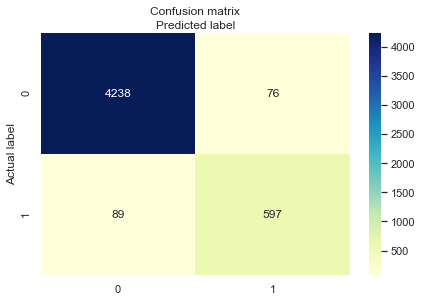

In [25]:
#Defining training and testing groups
x_train, x_test, y_train, y_test = train_test_split(features_hc, target, test_size = 0.5, random_state = 4)

#Training the model previously defined
dtc.fit(x_train, y_train)

#Obtaining and printing out results from the model (Confusion Matrix)
predicted = dtc.predict(x_test)
cm = metrics.confusion_matrix(y_test,predicted)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

#Printing the numerical result of the confusion matrix
print("\n Accuracy score: {:.5f}".format(dtc.score(x_test, y_test)))
misclassification_error = (FP + FN) / float(TP + TN + FP + FN)
print("\n Misclassification Rate: {:.5f}".format(misclassification_error))
sensitivity = TP / float(FN + TP)
print("\n True Positive Rate: {:.5f}".format(sensitivity))
specificity = TN / (TN + FP)
print("\n True Negative Rate: {:.5f}".format(specificity))
precision = TP / float(TP + FP)
print("\n Precision : {:.5f}".format(precision))
prevalence =  float(FN + TP)/float(TP + TN + FP + FN)
print("\n Prevalence : {:.5f}".format(prevalence))
fscore = (2 * precision * sensitivity) / (precision + sensitivity)
print("\n F score : {:.5f}".format(fscore))
print("\n False Positive Rate: {:.5f}".format(1-specificity))

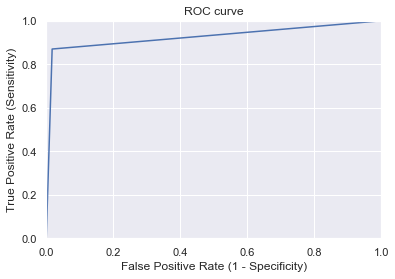

In [26]:
fpr, tpr, thresholds = metrics.roc_curve(y_test,predicted)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [27]:
#Repeat with KFold - creating groups
kf = KFold(n_splits = 5, random_state = 4, shuffle = True)


#Repeat with KFold - Training model (previously defined) and obtaining its output
kFoldTotal = 0
for k, (train_index, test_index) in enumerate(kf.split(features_hc)):
    x_train, x_test = features_hc.iloc[train_index], features_hc.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]
    dtc.fit(x_train, y_train)
    kFoldTotal += dtc.score(x_test, y_test)
    print("[fold {0}] score: {1:.5f}".format(k, dtc.score(x_test, y_test)))

#Printing out the results
roundedTotal = round(kFoldTotal/5, 5)
print("\nKNN mean score [5 folds] = " + str(roundedTotal))

[fold 0] score: 0.97400
[fold 1] score: 0.96600
[fold 2] score: 0.96450
[fold 3] score: 0.97300
[fold 4] score: 0.97100

KNN mean score [5 folds] = 0.9697
